In [36]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import *

In [38]:
! rm HDI_2017_components.csv*
! wget https://raw.githubusercontent.com/brunomurino/ML_projects/master/datasets/HDI_2017_components.csv
    
hdi_components = spark.read.load('HDI_2017_components.csv', # <class 'pyspark.sql.dataframe.DataFrame'>
                    format='csv', 
                    header='true',
                    inferSchema='true')
hdi_components.createOrReplaceTempView('hdi_components')

! ls

spark.catalog.listTables()
hdi_components.columns

rm: cannot remove 'HDI_2017_components.csv*': No such file or directory
--2018-11-01 07:28:07--  https://raw.githubusercontent.com/brunomurino/ML_projects/master/datasets/HDI_2017_components.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9755 (9.5K) [text/plain]
Saving to: 'HDI_2017_components.csv'

HDI_2017_components 100%[===================>]   9.53K  --.-KB/s    in 0s      

2018-11-01 07:28:08 (128 MB/s) - 'HDI_2017_components.csv' saved [9755/9755]

HDI_2017_components.csv  hdi_model.h5  logs  spark-events  user-libs


['HDI rank',
 'Country',
 'Human Development Index (HDI) ',
 'Life expectancy at birth (years)',
 'Expected years of schooling ',
 'Mean years of schooling',
 'Gross national income (GNI) per capita',
 'GNI per capita rank minus HDI rank',
 'HDI rank (2016)']

In [16]:
# Rename dataframe for more readable manipulation and to keep original intact.

df = hdi_components

# Trim column names for better manipulation

for col in df.columns:
    df = df.withColumnRenamed(col, col.strip())
    
# Remove undesired characters such as thousands separators and currency symbols

from pyspark.sql.functions import regexp_replace
df = df.withColumn("Gross national income (GNI) per capita",regexp_replace(df["Gross national income (GNI) per capita"], ",", ""))

# Check and change column data types

df = df.withColumn("Gross national income (GNI) per capita", df["Gross national income (GNI) per capita"].cast('double'))
df = df.withColumn("HDI rank (2016)", df["HDI rank (2016)"].cast('double'))

In [17]:
# Define FEATURES and TARGETS

FEATURES = [
#     'HDI rank',
#     'Country',
#     'Human Development Index (HDI) ',
    'Life expectancy at birth (years)',
    'Expected years of schooling',
    'Mean years of schooling',
    'Gross national income (GNI) per capita',
#     'GNI per capita rank minus HDI rank',
#     'HDI rank (2016)'
]
TARGETS = [
    'HDI rank',
#     'Country',
    'Human Development Index (HDI)',
#     'Life expectancy at birth (years)',
#     'Expected years of schooling ',
#     'Mean years of schooling',
#     'Gross national income (GNI) per capita',
#     'GNI per capita rank minus HDI rank',
#     'HDI rank (2016)'
]

# Keep only FEATURES and TARGETS

df = df.select(FEATURES + TARGETS)

# # Check final schema
df.printSchema()

# # Check first examples
df.show(5)

root
 |-- Life expectancy at birth (years): double (nullable = true)
 |-- Expected years of schooling: double (nullable = true)
 |-- Mean years of schooling: double (nullable = true)
 |-- Gross national income (GNI) per capita: double (nullable = true)
 |-- HDI rank: integer (nullable = true)
 |-- Human Development Index (HDI): double (nullable = true)

+--------------------------------+---------------------------+-----------------------+--------------------------------------+--------+-----------------------------+
|Life expectancy at birth (years)|Expected years of schooling|Mean years of schooling|Gross national income (GNI) per capita|HDI rank|Human Development Index (HDI)|
+--------------------------------+---------------------------+-----------------------+--------------------------------------+--------+-----------------------------+
|                            82.3|                       17.9|                   12.6|                               68012.0|       1|               

In [18]:
# Scale features to 0-1 linearly

max_target = []
min_target = []

for col in FEATURES+TARGETS:
    max_val = df.agg({col: "max"}).collect()[0][0]
    min_val = df.agg({col: "min"}).collect()[0][0]
    if col in TARGETS:
        # When scaling the targets, we need to save the scaling parameters so later we can convert our predictions back to the original scale.
        # This portion of the code only makes sense if you have just one target, otherwise you need to keep track of the other scaling parameters 
        max_target.append(max_val)
        min_target.append(min_val)
    df = df.withColumn(col, (df[col]-min_val)/(max_val-min_val))  
    
max_target = np.array(max_target)
min_target = np.array(min_target)

df.show(5)

+--------------------------------+---------------------------+-----------------------+--------------------------------------+--------------------+-----------------------------+
|Life expectancy at birth (years)|Expected years of schooling|Mean years of schooling|Gross national income (GNI) per capita|            HDI rank|Human Development Index (HDI)|
+--------------------------------+---------------------------+-----------------------+--------------------------------------+--------------------+-----------------------------+
|              0.9435736677115988|         0.7222222222222221|     0.8809523809523809|                    0.5798200680125694|                 0.0|                          1.0|
|               0.981191222570533|         0.6277777777777778|     0.9444444444444445|                    0.4903964530153674|0.005319148936170213|           0.9849749582637729|
|              0.9686520376175548|                        1.0|     0.9047619047619048|                    0.3693082

In [19]:
# Split the dataset in 3 parts

weights = [.9, .1]
seed = 41
training, test = df.randomSplit(weights, seed)

X_train = training.select(FEATURES)
Y_train = training.select(TARGETS)

# X_vali = validation.select(FEATURES)
# Y_vali = validation.select(TARGETS)

X_test = test.select(FEATURES)
Y_test = test.select(TARGETS)

print("The number of examples in the traning set is {}".format(X_train.count()))
# print("The number of examples in the validation set is {}".format(X_vali.count()))
print("The number of examples in the test set is {}".format(X_test.count()))

The number of examples in the traning set is 172
The number of examples in the test set is 17


In [20]:
# Define the model:

model = Sequential()
model.add(Dense(50, input_dim=len(FEATURES), activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(50, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(50, activation = "relu"))
model.add(Dropout(0.15))
model.add(Dense(len(TARGETS), activation = "relu"))
model.compile(loss = 'mse', optimizer = 'adam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 50)                250       
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 102       
Total para

In [21]:
# Train model
model.fit(
    x = np.array(X_train.collect()),
    y = np.array(Y_train.collect()),
    validation_split = 0.2,
#     validation_data = (np.array(Y_vali.collect()), np.array(Y_vali.collect())),
    epochs = 30,
    verbose = 0,
    shuffle = True,
#     batch_size = 90,
)

In [22]:
test_mse = model.evaluate(x=np.array(X_test.collect()), y=np.array(Y_test.collect()))
print("The MSE for the test set is {}".format(test_mse))

17/17 [==============================] - 0s 69us/step
The MSE for the test set is 0.007827150635421276


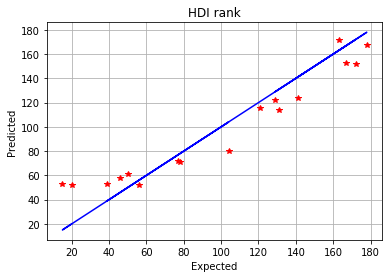

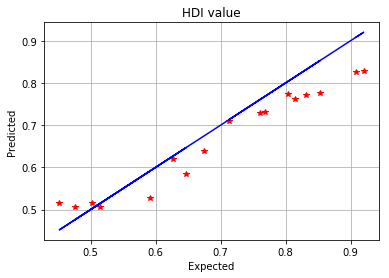

In [31]:
prediction_scaled = model.predict(np.array(X_test.collect()))

# Scale back the targets using saved parameters
prediction = np.array([min_target + row*(max_target-min_target) for row in prediction_scaled])
# print(prediction)

# Truncates first column since values must be integers
# prediction[:,0] = np.trunc(prediction[:,0])

# Get true target values
prediction_true_scaled = np.array(Y_test.collect())

# Scale back
prediction_true = np.array([min_target + row*(max_target-min_target) for row in prediction_true_scaled])
# print(prediction_true)

# prediction_true[:,0]
# print(prediction[:,0])

from matplotlib import pyplot as plt

plt.plot(prediction_true[:,0], prediction[:,0], '*r', prediction_true[:,0], prediction_true[:,0], 'b')
plt.title('HDI rank')
plt.xlabel('Expected')
plt.ylabel('Predicted')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

plt.plot(prediction_true[:,1], prediction[:,1], '*r', prediction_true[:,1], prediction_true[:,1], 'b')
plt.title('HDI value')
plt.xlabel('Expected')
plt.ylabel('Predicted')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

In [32]:
model.save('hdi_model.h5')

In [33]:
from keras.models import load_model

model2 = load_model('hdi_model.h5')

In [34]:
predict_scaled = model2.predict(np.array(X_test.collect()))
predict = min_target + predict_scaled*(max_target-min_target)
predict

array([[ 124.14521646,    0.52810443],
       [ 171.48832297,    0.50592636],
       [ 151.60940266,    0.50584938],
       [ 152.74648714,    0.51457724],
       [ 122.39593244,    0.58529885],
       [ 167.72463989,    0.51485883],
       [ 114.15001369,    0.62101864],
       [ 115.50934029,    0.63967819],
       [  70.74520826,    0.7283976 ],
       [  52.9225738 ,    0.77544879],
       [  52.07337427,    0.77412724],
       [  80.22493327,    0.71042194],
       [  72.17850351,    0.73075658],
       [  61.0006932 ,    0.7618468 ],
       [  57.44407415,    0.7705024 ],
       [  52.73341084,    0.82830896],
       [  51.68986011,    0.82497667]])